In [1]:
import pandas as pd
import numpy as np          # For mathematical calculations
from matplotlib import pyplot as plt     ## For plotting graphs /
from pandas import Series            ## To work on Series
from datetime import datetime         # To access datetime 
%matplotlib inline
import warnings                       # To ignore the warnings warnings.filterwarnings("ignore")

## Prob. Stat
Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file

Steps 
a) Understanding Data:
        1) Hypothesis Generation
        2) Getting the system ready and loading the data
        3) Dataset Structure and Content
        4) Feature Extraction
        5) Exploratory Analysis
b) Forecasting using Multiple Modeling Techniques:
        1) Splitting the data into training and validation part
        2) Modeling techniques
        3) Holt’s Linear Trend Model on daily time series
        4) Holt Winter’s Model on daily time series
        5) Introduction to ARIMA model
        6) Parameter tuning for ARIMA model
        7) SARIMAX model on daily time series

In [2]:
# Loading data

train_dat= pd .read_csv("C:\\Python\\ML\\time\\Train_Time.csv")
test_dat= pd .read_csv("C:\\Python\\ML\\time\\Test_Time.csv")

In [3]:
train_dat.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
test_dat.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [5]:
# TO copy train & test , to avoid loosing of original dataset(like backup)
train_Original=train_dat.copy()
test_Original=test_dat.copy()

In [6]:
train_dat.columns , test_dat.columns


(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [7]:
train_Original.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


## Hypothesis Generation

Hypothesis generation helps us to point out the factors which might affect our dependent variable. Below are some of the hypotheses which I think can affect the passenger count(dependent variable for this time series problem) on the JetRail:

1. 1There will be an increase in the traffic as the years pass by.
            Explanation - Population has a general upward trend with time, so I can expect more people to travel by        JetRail. Also, generally companies expand their businesses over time leading to more customers travelling           through JetRail.
2. The traffic will be high from May to October.
Explanation - Tourist visits generally increases during this time perion.
3. Traffic on weekdays will be more as compared to weekends/holidays.
Explanation - People will go to office on weekdays and hence the traffic will be more
4. Traffic during the peak hours will be high.
Explanation - People will travel to work, college

## We have ID, Datetime and corresponding count of passengers in the train file. For test file we have ID and Datetime only so we have to predict the Count for test file

In [8]:
# Understans features datatyes
train_dat.dtypes, test_dat.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

##  1. ID and Count are in integer format while the Datetime is in object format for the train file.
2. Id is in integer and Datetime is in object format for test file.

In [9]:
# TO check the shape of dataset
train_dat.shape , test_dat.shape

((18288, 3), (5112, 2))

#### 4. Feature _ extraction
TO Extract data & time from DATE_TIME Column , its required to chnage datatime column datatype from object to Datatime

In [10]:
# Updated for time format for both train , train_original DS

train_dat['Datetime']= pd.to_datetime(train_dat.Datetime,format='%d-%m-%Y %H:%M')
test_dat['Datetime']= pd.to_datetime(test_dat.Datetime,format='%d-%m-%Y %H:%M')
train_Original['Datetime']= pd.to_datetime(train_Original.Datetime,format='%d-%m-%Y %H:%M')
test_Original['Datetime']= pd.to_datetime(test_Original.Datetime,format='%d-%m-%Y %H:%M')

In [11]:
train_dat.dtypes

ID                   int64
Datetime    datetime64[ns]
Count                int64
dtype: object

##  We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

In [12]:
for i in (train_dat,test_dat,train_Original,test_Original):
    i['year']=i.Datetime.dt.year
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour
    
    

In [13]:
train_dat.head(10)

,ID,Datetime,Count,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4
5,5,2012-08-25 05:00:00,2,2012,8,25,5
6,6,2012-08-25 06:00:00,2,2012,8,25,6
7,7,2012-08-25 07:00:00,2,2012,8,25,7
8,8,2012-08-25 08:00:00,6,2012,8,25,8
9,9,2012-08-25 09:00:00,2,2012,8,25,9


## We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic.

We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.

Values of 5 and 6 represents that the days are weekend.

In [14]:
train_dat['day of week']=train_dat['Datetime'].dt.dayofweek 
temp = train_dat['Datetime']

## Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

In [15]:
def wkndnt(row):
    if row.dayofweek ==5 or row.dayofweek ==6:
        return 1
    else:
        return 0
    
temp2 = train_dat['Datetime'].apply(wkndnt) 
train_dat['weekend']=temp2

In [16]:
train_dat.tail(10)

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
18278,18278,2014-09-25 14:00:00,616,2014,9,25,14,3,0
18279,18279,2014-09-25 15:00:00,686,2014,9,25,15,3,0
18280,18280,2014-09-25 16:00:00,654,2014,9,25,16,3,0
18281,18281,2014-09-25 17:00:00,622,2014,9,25,17,3,0
18282,18282,2014-09-25 18:00:00,680,2014,9,25,18,3,0
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,0
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,0
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,0
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,0
18287,18287,2014-09-25 23:00:00,534,2014,9,25,23,3,0


##  Set index column of  dataframe to datatime index

In [17]:
train_dat.index=train_dat['Datetime']    # indexing the Datetime to get the time period on the x-axis. 
train_dat.head(10)

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,,
2012-08-25 00:00:00,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1
2012-08-25 05:00:00,5,2012-08-25 05:00:00,2,2012,8,25,5,5,1
2012-08-25 06:00:00,6,2012-08-25 06:00:00,2,2012,8,25,6,5,1
2012-08-25 07:00:00,7,2012-08-25 07:00:00,2,2012,8,25,7,5,1
2012-08-25 08:00:00,8,2012-08-25 08:00:00,6,2012,8,25,8,5,1


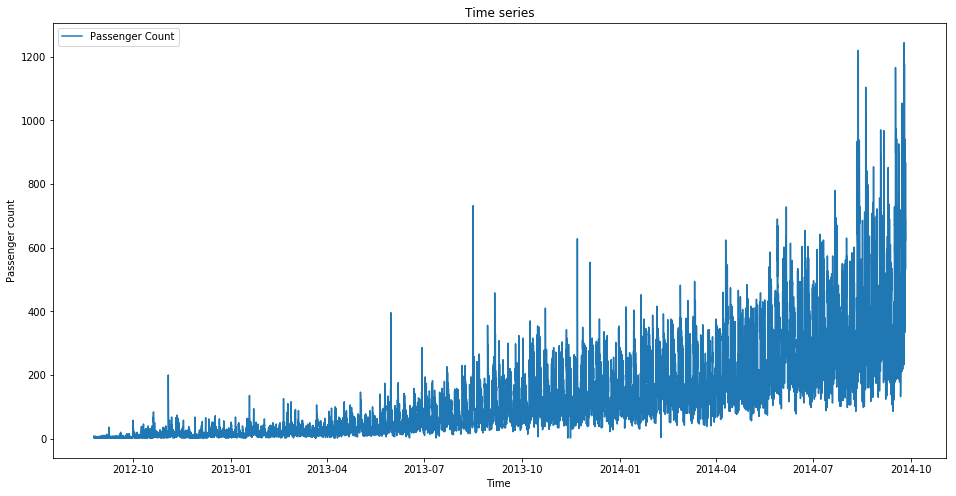

In [18]:
train_dat.drop('ID',1)    #  # drop ID variable to get only the Datetime on x-axis. 

#  plot graph for time series
plt.figure(figsize=(16,8))
ts=train_dat['Count']
plt.plot(ts,label='Passenger Count')
plt.title('Time series')
plt.xlabel("Time ")
plt.ylabel("Passenger count") 
plt.legend(loc='best')

In [19]:
# EDA (Explotaroy Data ANalysis)
train_dat.groupby('year')['Count'].mean()

year
2012     11.282946
2013     78.306849
2014    283.017102
Name: Count, dtype: float64

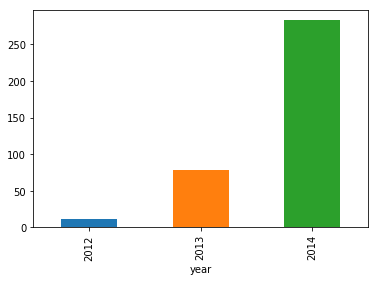

In [20]:
train_dat.groupby('year')['Count'].mean().plot.bar()

In [21]:
train_dat.groupby('month')['Count'].mean()

month
1      92.817204
2     111.196429
3     103.791667
4     137.680556
5     155.055108
6     186.723611
7     209.071237
8     220.497585
9     181.958824
10     75.459677
11     78.413889
12     86.533602
Name: Count, dtype: float64

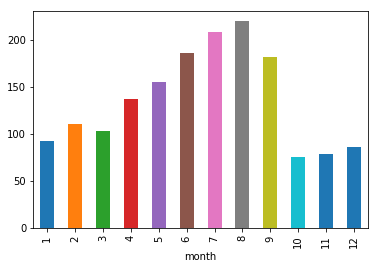

In [22]:
train_dat.groupby('month')['Count'].mean().plot.bar()

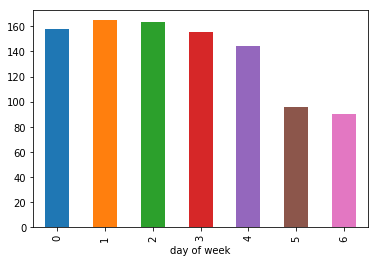

In [23]:
train_dat.groupby('day of week')['Count'].mean().plot.bar()

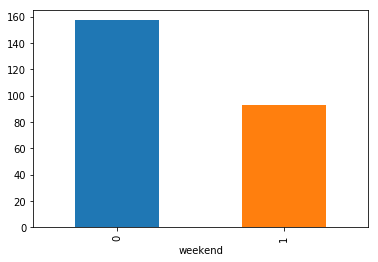

In [24]:
train_dat.groupby('weekend')['Count'].mean().plot.bar()

## Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let’s look at the monthly mean of each year separately## 

In [25]:
train_dat.groupby(['year','month'])['Count'].mean()


year  month
2012  8          2.952381
      9          4.444444
      10        10.986559
      11        15.827778
      12        15.680108
2013  1         18.430108
      2         22.190476
      3         23.588710
      4         34.405556
      5         45.612903
      6         57.333333
      7         74.787634
      8        100.137097
      9        120.744444
      10       139.932796
      11       141.000000
      12       157.387097
2014  1        167.204301
      2        200.202381
      3        183.994624
      4        240.955556
      5        264.497312
      6        316.113889
      7        343.354839
      8        389.981183
      9        468.433333
Name: Count, dtype: float64

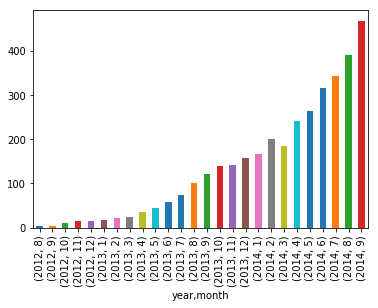

In [26]:
train_dat.groupby(['year','month'])['Count'].mean().plot.bar()

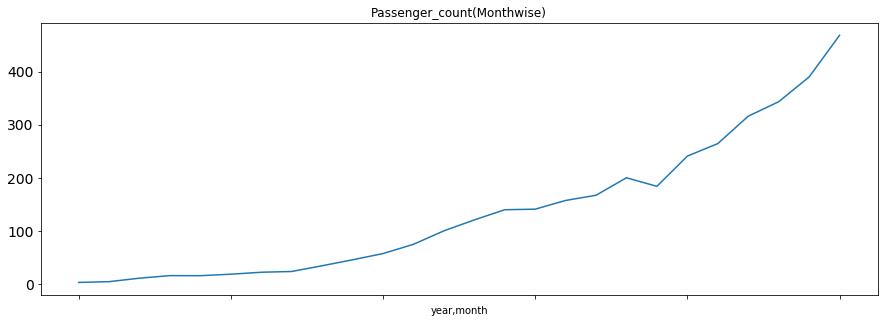

In [27]:
temp=train_dat.groupby(['year','month'])['Count'].mean()
temp.plot(figsize=(15,5),title='Passenger_count(Monthwise)',fontsize=14)

## We see that the months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.
Since there is an increasing trend in our time series, the mean value for rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.

In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

In [28]:
# daily mean of passenger count.
train_dat.groupby('day')['Count'].mean()

day
1     129.256667
2     133.830000
3     135.906667
4     142.310000
5     149.976667
6     135.200000
7     130.216667
8     128.960000
9     139.873333
10    148.243333
11    151.950000
12    141.470000
13    135.356667
14    127.956667
15    130.103333
16    147.320000
17    142.363333
18    142.346667
19    146.853333
20    141.690000
21    148.650000
22    152.186667
23    150.556667
24    153.983333
25    141.618590
26    132.620000
27    125.113333
28    130.513333
29    126.065217
30    129.684783
31    130.105556
Name: Count, dtype: float64

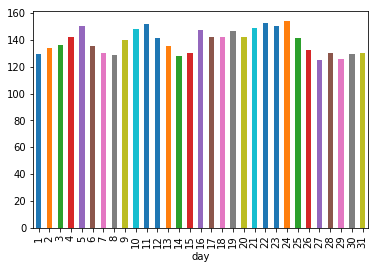

In [29]:
train_dat.groupby('day')['Count'].mean().plot.bar()

## We are not getting much insights from day wise count of the passengers.

We also made a hypothesis that the traffic will be more during peak hours. So let’s see the mean of hourly passenger count.

In [30]:
train_dat.groupby('Hour')['Count'].mean()

Hour
0     147.695538
1     117.868766
2      99.753281
3      82.422572
4      69.375328
5      62.102362
6      66.776903
7      77.443570
8      89.181102
9     115.241470
10    163.572178
11    181.341207
12    183.262467
13    162.081365
14    173.304462
15    171.115486
16    166.748031
17    170.632546
18    174.832021
19    185.514436
20    178.272966
21    166.398950
22    167.002625
23    163.055118
Name: Count, dtype: float64

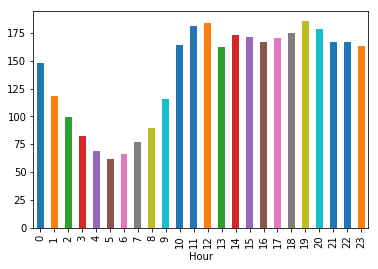

In [31]:
train_dat.groupby('Hour')['Count'].mean().plot.bar()

## It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.
After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

## Let’s try to validate our hypothesis in which we assumed that the traffic will be more on weekdays.

In [32]:
train_dat.groupby('weekend')['Count'].mean()

weekend
0    157.268536
1     93.266055
Name: Count, dtype: float64

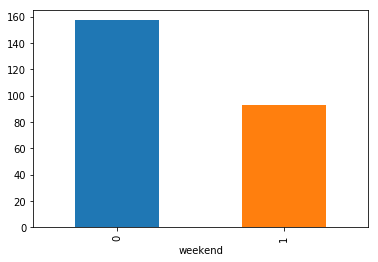

In [33]:
train_dat.groupby('weekend')['Count'].mean().plot.bar()

##  It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis.
Now we will try to look at the day wise passenger count.

Note - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.

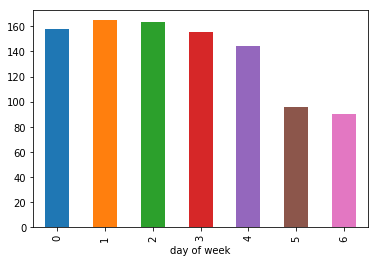

In [34]:
train_dat.groupby('day of week')['Count'].mean().plot.bar()

##  As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [35]:
train_dat.aa = pd.to_datetime(train_dat.Datetime,format='%d-%m-%Y %H:%M') 
train_dat.index = train_dat.aa

C:\Users\inshn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


##  Hourly basis series

In [36]:
# Hourly time series 
hourly = train_dat.resample('H').mean()
hourly 

,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2012-08-25 00:00:00,0,8,2012,8,25,0,5,1
2012-08-25 01:00:00,1,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2,6,2012,8,25,2,5,1
2012-08-25 03:00:00,3,2,2012,8,25,3,5,1
2012-08-25 04:00:00,4,2,2012,8,25,4,5,1
2012-08-25 05:00:00,5,2,2012,8,25,5,5,1
2012-08-25 06:00:00,6,2,2012,8,25,6,5,1
2012-08-25 07:00:00,7,2,2012,8,25,7,5,1
2012-08-25 08:00:00,8,6,2012,8,25,8,5,1


In [37]:
# Converting to daily mean 
daily = train_dat.resample('D').mean() 
daily.count()

ID             762
Count          762
year           762
month          762
day            762
Hour           762
day of week    762
weekend        762
dtype: int64

In [38]:
# Converting to weekly mean 
weekly = train_dat.resample('W').mean()
weekly.shape

(110, 8)

In [39]:
# Converting to monthly mean 
monthly = train_dat.resample('M').mean()
monthly

,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2012-08-31,83.5,2.952381,2012.0,8.0,28.0,11.5,3.000000,0.285714
2012-09-30,527.5,4.444444,2012.0,9.0,15.5,11.5,3.166667,0.333333
2012-10-31,1259.5,10.986559,2012.0,10.0,16.0,11.5,2.806452,0.258065
2012-11-30,1991.5,15.827778,2012.0,11.0,15.5,11.5,3.033333,0.266667
2012-12-31,2723.5,15.680108,2012.0,12.0,16.0,11.5,3.064516,0.322581
2013-01-31,3467.5,18.430108,2013.0,1.0,16.0,11.5,2.903226,0.258065
2013-02-28,4175.5,22.190476,2013.0,2.0,14.5,11.5,3.000000,0.285714
2013-03-31,4883.5,23.588710,2013.0,3.0,16.0,11.5,3.193548,0.322581
2013-04-30,5615.5,34.405556,2013.0,4.0,15.5,11.5,2.833333,0.266667


## Let’s look at the hourly, daily, weekly and monthly time series.

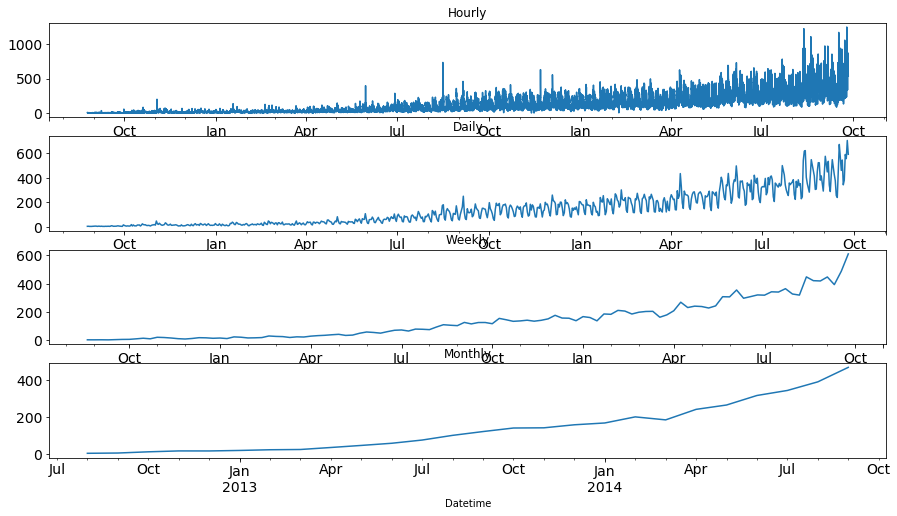

In [40]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 
plt.show()


## But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [41]:
test_dat.ab = pd.to_datetime(test_dat.Datetime,format='%d-%m-%Y %H:%M') 
test_dat.index = test_dat.ab





C:\Users\inshn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [42]:
# Converting to daily mean 
test_dat = test_dat.resample('D').mean() 
test_dat

,ID,year,month,day,Hour
Datetime,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5
2014-09-27,18323.5,2014.0,9.0,27.0,11.5
2014-09-28,18347.5,2014.0,9.0,28.0,11.5
2014-09-29,18371.5,2014.0,9.0,29.0,11.5
2014-09-30,18395.5,2014.0,9.0,30.0,11.5
2014-10-01,18419.5,2014.0,10.0,1.0,11.5
2014-10-02,18443.5,2014.0,10.0,2.0,11.5
2014-10-03,18467.5,2014.0,10.0,3.0,11.5
2014-10-04,18491.5,2014.0,10.0,4.0,11.5


In [43]:
test_dat.shape

(213, 5)

In [44]:

# Converting to daily mean 
train_dat = train_dat.resample('D').mean()

In [45]:
train_dat.tail()

,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2014-09-21,18179.5,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0
2014-09-22,18203.5,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0
2014-09-23,18227.5,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0
2014-09-24,18251.5,702.333333,2014.0,9.0,24.0,11.5,2.0,0.0
2014-09-25,18275.5,589.666667,2014.0,9.0,25.0,11.5,3.0,0.0


##  Splitting data into train & test split dataset

In [46]:
train1=train_dat.loc['2012-08-25':'2014-06-24']
valid=train_dat.loc['2014-06-25':'2014-09-25']

In [47]:
train2=train_dat.loc['2014-04-01':'2014-04-30']
train2.Count.mean()

240.9555555555555

In [48]:
valid

,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2014-06-25,16067.5,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0
2014-06-26,16091.5,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0
2014-06-27,16115.5,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0
2014-06-28,16139.5,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0
2014-06-29,16163.5,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0
2014-06-30,16187.5,314.500000,2014.0,6.0,30.0,11.5,0.0,0.0
2014-07-01,16211.5,326.500000,2014.0,7.0,1.0,11.5,1.0,0.0
2014-07-02,16235.5,326.083333,2014.0,7.0,2.0,11.5,2.0,0.0
2014-07-03,16259.5,323.916667,2014.0,7.0,3.0,11.5,3.0,0.0


In [49]:
train1.tail()

,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2014-06-20,15947.5,379.916667,2014.0,6.0,20.0,11.5,4.0,0.0
2014-06-21,15971.5,220.083333,2014.0,6.0,21.0,11.5,5.0,1.0
2014-06-22,15995.5,230.833333,2014.0,6.0,22.0,11.5,6.0,1.0
2014-06-23,16019.5,419.416667,2014.0,6.0,23.0,11.5,0.0,0.0
2014-06-24,16043.5,372.166667,2014.0,6.0,24.0,11.5,1.0,0.0


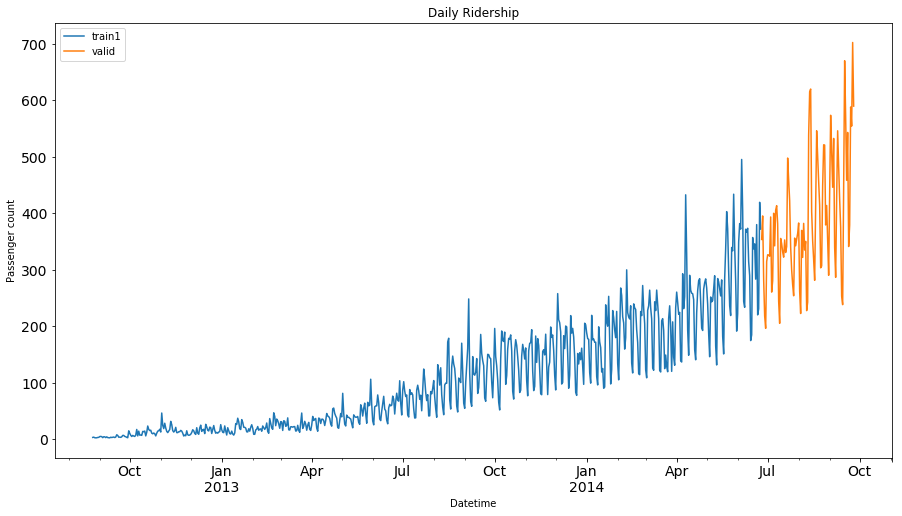

In [50]:
train1.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train1') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')#legend to show category
plt.show()

## Model in Time series Forescast
 1. Naive Approach
 2.) Moving Average
 3.Simple Exponential Smoothing
 4. Holt’s Linear Trend Model

In [51]:
# 1. Naive Approach
# In this forecasting technique, we assume that the next expected point is equal to the last observed point. 
#So we can expect a straight horizontal line as the prediction
dd=np.asarray(train1.Count)
y_hat=valid.copy()
y_hat

,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2014-06-25,16067.5,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0
2014-06-26,16091.5,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0
2014-06-27,16115.5,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0
2014-06-28,16139.5,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0
2014-06-29,16163.5,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0
2014-06-30,16187.5,314.500000,2014.0,6.0,30.0,11.5,0.0,0.0
2014-07-01,16211.5,326.500000,2014.0,7.0,1.0,11.5,1.0,0.0
2014-07-02,16235.5,326.083333,2014.0,7.0,2.0,11.5,2.0,0.0
2014-07-03,16259.5,323.916667,2014.0,7.0,3.0,11.5,3.0,0.0


In [52]:
y_hat['naive']=dd[len(dd)-1]     #assigned last index value of train DS count value to all test data(Navie)column 
#as per navie approach
y_hat['naive']

Datetime
2014-06-25    372.166667
2014-06-26    372.166667
2014-06-27    372.166667
2014-06-28    372.166667
2014-06-29    372.166667
2014-06-30    372.166667
2014-07-01    372.166667
2014-07-02    372.166667
2014-07-03    372.166667
2014-07-04    372.166667
2014-07-05    372.166667
2014-07-06    372.166667
2014-07-07    372.166667
2014-07-08    372.166667
2014-07-09    372.166667
2014-07-10    372.166667
2014-07-11    372.166667
2014-07-12    372.166667
2014-07-13    372.166667
2014-07-14    372.166667
2014-07-15    372.166667
2014-07-16    372.166667
2014-07-17    372.166667
2014-07-18    372.166667
2014-07-19    372.166667
2014-07-20    372.166667
2014-07-21    372.166667
2014-07-22    372.166667
2014-07-23    372.166667
2014-07-24    372.166667
                 ...    
2014-08-27    372.166667
2014-08-28    372.166667
2014-08-29    372.166667
2014-08-30    372.166667
2014-08-31    372.166667
2014-09-01    372.166667
2014-09-02    372.166667
2014-09-03    372.166667
2014-09-04    37

In [53]:
y_hat.head()

,ID,Count,year,month,day,Hour,day of week,weekend,naive
Datetime,,,,,,,,,
2014-06-25,16067.5,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0,372.166667
2014-06-26,16091.5,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0,372.166667
2014-06-27,16115.5,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0,372.166667
2014-06-28,16139.5,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0,372.166667
2014-06-29,16163.5,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0,372.166667


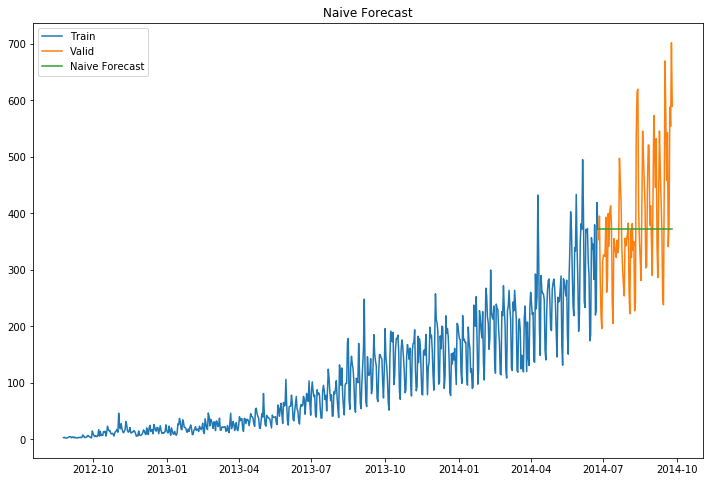

In [54]:
plt.figure(figsize=(12,8)) 
plt.plot(train1.index, train1.Count, label='Train') 
plt.plot(valid.index,valid.Count, label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

##  Now Predcition is calculated using RMSE (Root Mean Square Error)
RMSE standard deviation of the residuals.
Residuals are a measure of how far from the regression line data points are.

In [55]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

111.79050467496724


## We can infer that this method is not suitable for datasets with high variability. We can reduce the rmse value by adopting different techniques.

## 2.Moving Average-
In this technique we will take the average of the passenger counts for last few time periods only.
Here the predictions are made on the basis of the average of last few points instead of taking all the previously known values.

Lets try the rolling mean for last 10, 20, 50 days and visualize the results

In [56]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = train1['Count'].rolling(10).mean().iloc[-1]    # average of last 10 observations. 

# here iloc() refers to index value oflost row in DS
y_hat_avg['moving_avg_forecast']



Datetime
2014-06-25    313.033333
2014-06-26    313.033333
2014-06-27    313.033333
2014-06-28    313.033333
2014-06-29    313.033333
2014-06-30    313.033333
2014-07-01    313.033333
2014-07-02    313.033333
2014-07-03    313.033333
2014-07-04    313.033333
2014-07-05    313.033333
2014-07-06    313.033333
2014-07-07    313.033333
2014-07-08    313.033333
2014-07-09    313.033333
2014-07-10    313.033333
2014-07-11    313.033333
2014-07-12    313.033333
2014-07-13    313.033333
2014-07-14    313.033333
2014-07-15    313.033333
2014-07-16    313.033333
2014-07-17    313.033333
2014-07-18    313.033333
2014-07-19    313.033333
2014-07-20    313.033333
2014-07-21    313.033333
2014-07-22    313.033333
2014-07-23    313.033333
2014-07-24    313.033333
                 ...    
2014-08-27    313.033333
2014-08-28    313.033333
2014-08-29    313.033333
2014-08-30    313.033333
2014-08-31    313.033333
2014-09-01    313.033333
2014-09-02    313.033333
2014-09-03    313.033333
2014-09-04    31

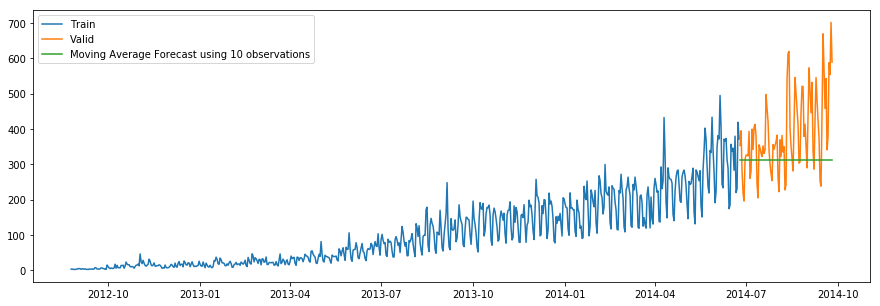

In [57]:
plt.figure(figsize=(15,5)) 
plt.plot(train1['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 

In [58]:
y_hat_avg.head()

,ID,Count,year,month,day,Hour,day of week,weekend,moving_avg_forecast
Datetime,,,,,,,,,
2014-06-25,16067.5,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0,313.033333
2014-06-26,16091.5,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0,313.033333
2014-06-27,16115.5,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0,313.033333
2014-06-28,16139.5,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0,313.033333
2014-06-29,16163.5,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0,313.033333


In [59]:
# To find avaerage of Last 10 value of dataset
ss=train1.loc['2014-06-14':'2014-06-23']
ss.Count.mean()

293.275

In [60]:
# Now apply for 20 Observation


In [61]:
y_hat_avg1 = valid.copy() 
y_hat_avg1['moving_avg_forecast'] = train1['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
y_hat_avg1['moving_avg_forecast']

Datetime
2014-06-25    319.916667
2014-06-26    319.916667
2014-06-27    319.916667
2014-06-28    319.916667
2014-06-29    319.916667
2014-06-30    319.916667
2014-07-01    319.916667
2014-07-02    319.916667
2014-07-03    319.916667
2014-07-04    319.916667
2014-07-05    319.916667
2014-07-06    319.916667
2014-07-07    319.916667
2014-07-08    319.916667
2014-07-09    319.916667
2014-07-10    319.916667
2014-07-11    319.916667
2014-07-12    319.916667
2014-07-13    319.916667
2014-07-14    319.916667
2014-07-15    319.916667
2014-07-16    319.916667
2014-07-17    319.916667
2014-07-18    319.916667
2014-07-19    319.916667
2014-07-20    319.916667
2014-07-21    319.916667
2014-07-22    319.916667
2014-07-23    319.916667
2014-07-24    319.916667
                 ...    
2014-08-27    319.916667
2014-08-28    319.916667
2014-08-29    319.916667
2014-08-30    319.916667
2014-08-31    319.916667
2014-09-01    319.916667
2014-09-02    319.916667
2014-09-03    319.916667
2014-09-04    31

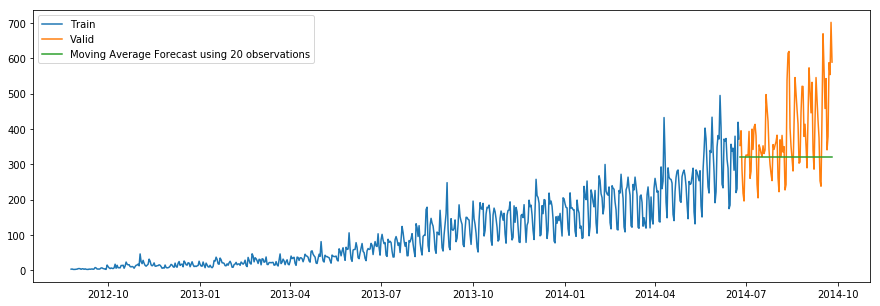

In [62]:
plt.figure(figsize=(15,5)) 
plt.plot(train1['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg1['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 

In [63]:
# For 50 value average observation 

y_hat_avg2 = valid.copy() 
y_hat_avg2['moving_avg_forecast'] = train1['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
y_hat_avg2['moving_avg_forecast']

Datetime
2014-06-25    296.626667
2014-06-26    296.626667
2014-06-27    296.626667
2014-06-28    296.626667
2014-06-29    296.626667
2014-06-30    296.626667
2014-07-01    296.626667
2014-07-02    296.626667
2014-07-03    296.626667
2014-07-04    296.626667
2014-07-05    296.626667
2014-07-06    296.626667
2014-07-07    296.626667
2014-07-08    296.626667
2014-07-09    296.626667
2014-07-10    296.626667
2014-07-11    296.626667
2014-07-12    296.626667
2014-07-13    296.626667
2014-07-14    296.626667
2014-07-15    296.626667
2014-07-16    296.626667
2014-07-17    296.626667
2014-07-18    296.626667
2014-07-19    296.626667
2014-07-20    296.626667
2014-07-21    296.626667
2014-07-22    296.626667
2014-07-23    296.626667
2014-07-24    296.626667
                 ...    
2014-08-27    296.626667
2014-08-28    296.626667
2014-08-29    296.626667
2014-08-30    296.626667
2014-08-31    296.626667
2014-09-01    296.626667
2014-09-02    296.626667
2014-09-03    296.626667
2014-09-04    29

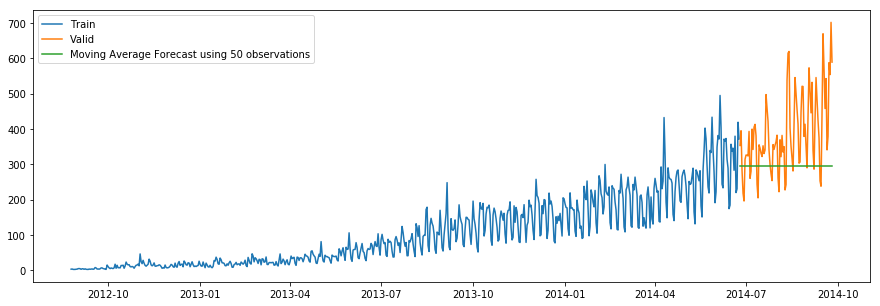

In [64]:
plt.figure(figsize=(15,5)) 
plt.plot(train1['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg2['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

## We can see that the predictions are getting weaker as we increase the number of observations.

In [65]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg2.moving_avg_forecast)) # 50 Observation
print(rms)

144.19175679986802


In [66]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg1.moving_avg_forecast))    #20 Observation
print(rms)

130.44984977550422


In [67]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))    #10 Observation
print(rms)

134.23733308950264


## Simple Exponential Smoothing

In [68]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(train1['Count'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
y_hat_avg['SES']

Datetime
2014-06-25    363.522492
2014-06-26    363.522492
2014-06-27    363.522492
2014-06-28    363.522492
2014-06-29    363.522492
2014-06-30    363.522492
2014-07-01    363.522492
2014-07-02    363.522492
2014-07-03    363.522492
2014-07-04    363.522492
2014-07-05    363.522492
2014-07-06    363.522492
2014-07-07    363.522492
2014-07-08    363.522492
2014-07-09    363.522492
2014-07-10    363.522492
2014-07-11    363.522492
2014-07-12    363.522492
2014-07-13    363.522492
2014-07-14    363.522492
2014-07-15    363.522492
2014-07-16    363.522492
2014-07-17    363.522492
2014-07-18    363.522492
2014-07-19    363.522492
2014-07-20    363.522492
2014-07-21    363.522492
2014-07-22    363.522492
2014-07-23    363.522492
2014-07-24    363.522492
                 ...    
2014-08-27    363.522492
2014-08-28    363.522492
2014-08-29    363.522492
2014-08-30    363.522492
2014-08-31    363.522492
2014-09-01    363.522492
2014-09-02    363.522492
2014-09-03    363.522492
2014-09-04    36

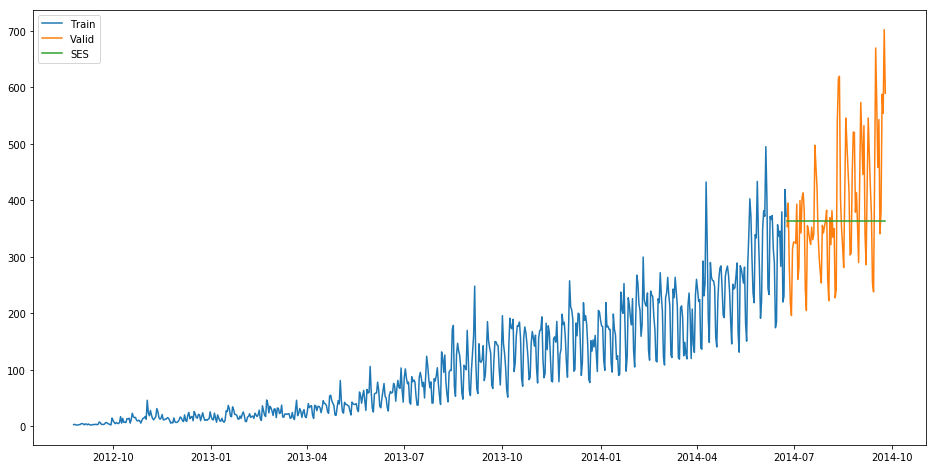

In [69]:
plt.figure(figsize=(16,8)) 
plt.plot(train1['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [70]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(rms)

113.43708111884514


## Holt’s Linear Trend Model

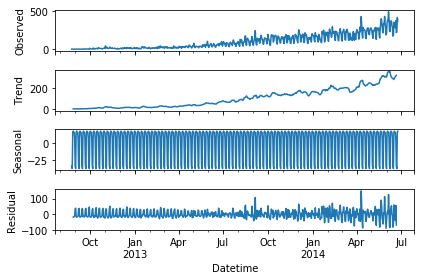

In [71]:
import statsmodels.api as sm 
sm.tsa.seasonal_decompose(train1.Count).plot() 
result = sm.tsa.stattools.adfuller(train1.Count) 
plt.show()

In [72]:
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(train1['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
y_hat_avg['Holt_linear']

Datetime
2014-06-25    334.650767
2014-06-26    337.159011
2014-06-27    339.667256
2014-06-28    342.175500
2014-06-29    344.683745
2014-06-30    347.191989
2014-07-01    349.700233
2014-07-02    352.208478
2014-07-03    354.716722
2014-07-04    357.224967
2014-07-05    359.733211
2014-07-06    362.241455
2014-07-07    364.749700
2014-07-08    367.257944
2014-07-09    369.766189
2014-07-10    372.274433
2014-07-11    374.782677
2014-07-12    377.290922
2014-07-13    379.799166
2014-07-14    382.307411
2014-07-15    384.815655
2014-07-16    387.323900
2014-07-17    389.832144
2014-07-18    392.340388
2014-07-19    394.848633
2014-07-20    397.356877
2014-07-21    399.865122
2014-07-22    402.373366
2014-07-23    404.881610
2014-07-24    407.389855
                 ...    
2014-08-27    492.670165
2014-08-28    495.178409
2014-08-29    497.686654
2014-08-30    500.194898
2014-08-31    502.703143
2014-09-01    505.211387
2014-09-02    507.719631
2014-09-03    510.227876
2014-09-04    51

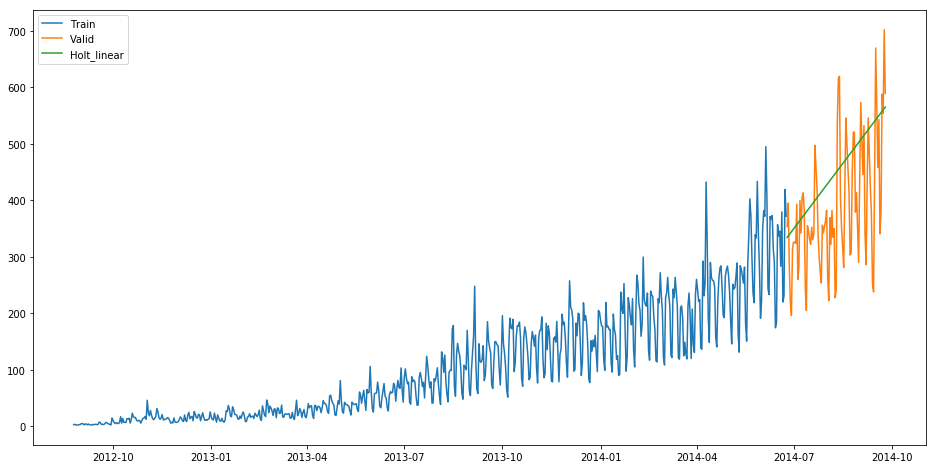

In [73]:
plt.figure(figsize=(16,8)) 
plt.plot(train1['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [74]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(rms)

112.94278345314041


##  Compare to all 4 model , Navie model RMSE is less, so prediction will be accurate using this model

## Now let’s try to make holt’s linear trend model on the daily time series and make predictions on the test dataset.
We will make predictions based on the daily time series and then will distribute that daily prediction to hourly predictions.
We have fitted the holt’s linear trend model on the train dataset and validated it using validation dataset.

In [75]:
submit= pd.read_csv("C:\\PYTHON\\ML\\time\\Submission.csv")

In [76]:
#Let’s make prediction for the test dataset based on holt’s linear trend model
predict= fit1.forecast(len(test_dat))
test_dat['Prediction']=predict


In [77]:
test_dat.head(30)

,ID,year,month,day,Hour,Prediction
Datetime,,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5,334.650767
2014-09-27,18323.5,2014.0,9.0,27.0,11.5,337.159011
2014-09-28,18347.5,2014.0,9.0,28.0,11.5,339.667256
2014-09-29,18371.5,2014.0,9.0,29.0,11.5,342.175500
2014-09-30,18395.5,2014.0,9.0,30.0,11.5,344.683745
2014-10-01,18419.5,2014.0,10.0,1.0,11.5,347.191989
2014-10-02,18443.5,2014.0,10.0,2.0,11.5,349.700233
2014-10-03,18467.5,2014.0,10.0,3.0,11.5,352.208478
2014-10-04,18491.5,2014.0,10.0,4.0,11.5,354.716722


## Remember this is the daily predictions. We have to convert these predictions to hourly basis. * To do so we will first calculate the ratio of passenger count for each hour of every day. * Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. * Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [78]:
train_Original.head()

,ID,Datetime,Count,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


In [79]:
# Calculating the hourly ratio of count
train_Original['ratio']=train_Original['Count']/train_Original['Count'].sum() 
train_Original['ratio']

0        3.148037e-06
1        7.870093e-07
2        2.361028e-06
3        7.870093e-07
4        7.870093e-07
5        7.870093e-07
6        7.870093e-07
7        7.870093e-07
8        2.361028e-06
9        7.870093e-07
10       7.870093e-07
11       2.361028e-06
12       1.574019e-06
13       7.870093e-07
14       2.361028e-06
15       7.870093e-07
16       7.870093e-07
17       7.870093e-07
18       7.870093e-07
19       7.870093e-07
20       7.870093e-07
21       2.361028e-06
22       7.870093e-07
23       7.870093e-07
24       1.574019e-06
25       2.361028e-06
26       7.870093e-07
27       1.574019e-06
28       7.870093e-07
29       7.870093e-07
             ...     
18258    3.801255e-04
18259    4.635485e-04
18260    3.966527e-04
18261    3.683204e-04
18262    3.336919e-04
18263    3.706814e-04
18264    2.699442e-04
18265    2.148535e-04
18266    2.164276e-04
18267    1.636979e-04
18268    1.353656e-04
18269    1.314306e-04
18270    1.636979e-04
18271    1.959653e-04
18272    1

In [104]:
train_Original.head()

,ID,Datetime,Count,year,month,day,Hour,ratio
0,0,2012-08-25 00:00:00,8,2012,8,25,0,3.148037e-06
1,1,2012-08-25 01:00:00,2,2012,8,25,1,7.870093e-07
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.361028e-06
3,3,2012-08-25 03:00:00,2,2012,8,25,3,7.870093e-07
4,4,2012-08-25 04:00:00,2,2012,8,25,4,7.870093e-07


In [117]:
# groupby hour based ratios

grp1 = train_Original.groupby('Hour')['ratio'].sum()
grp1


Hour
0     0.044287
1     0.035343
2     0.029911
3     0.024714
4     0.020802
5     0.018621
6     0.020023
7     0.023221
8     0.026741
9     0.034555
10    0.049047
11    0.054375
12    0.054951
13    0.048600
14    0.051965
15    0.051309
16    0.049999
17    0.051164
18    0.052423
19    0.055627
20    0.053455
21    0.049895
22    0.050076
23    0.048892
Name: ratio, dtype: float64

In [132]:
# Groupby to csv format 

ff= pd.DataFrame(grp1,index=None,columns=['Hour','ratio'])
ff.to_csv('sf3.csv')

In [133]:
ff.head()

,Hour,ratio
Hour,,
0,NaN,0.044287
1,NaN,0.035343
2,NaN,0.029911
3,NaN,0.024714
4,NaN,0.020802


In [139]:
t21=pd.read_csv("sf3.csv") 
t21=t21.drop('Hour.1',1)
t21.head(30)

,Hour,ratio
0,0,0.044287
1,1,0.035343
2,2,0.029911
3,3,0.024714
4,4,0.020802
5,5,0.018621
6,6,0.020023
7,7,0.023221
8,8,0.026741
9,9,0.034555


In [126]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test_dat, test_Original, on=('day','month', 'year'), how='left') 
#merge['Hour']=merge['Hour_y'] 
merge

,ID_x,year,month,day,Hour_x,Prediction,ID_y,Datetime,Hour_y
0,18299.5,2014,9,26,11.5,334.650767,18288,2014-09-26 00:00:00,0
1,18299.5,2014,9,26,11.5,334.650767,18289,2014-09-26 01:00:00,1
2,18299.5,2014,9,26,11.5,334.650767,18290,2014-09-26 02:00:00,2
3,18299.5,2014,9,26,11.5,334.650767,18291,2014-09-26 03:00:00,3
4,18299.5,2014,9,26,11.5,334.650767,18292,2014-09-26 04:00:00,4
5,18299.5,2014,9,26,11.5,334.650767,18293,2014-09-26 05:00:00,5
6,18299.5,2014,9,26,11.5,334.650767,18294,2014-09-26 06:00:00,6
7,18299.5,2014,9,26,11.5,334.650767,18295,2014-09-26 07:00:00,7
8,18299.5,2014,9,26,11.5,334.650767,18296,2014-09-26 08:00:00,8
9,18299.5,2014,9,26,11.5,334.650767,18297,2014-09-26 09:00:00,9


In [128]:
merge['Hour']=merge['Hour_y'] 
merge['Hour']
merge.head(10)


,ID_x,year,month,day,Hour_x,Prediction,ID_y,Datetime,Hour_y,Hour
0,18299.5,2014,9,26,11.5,334.650767,18288,2014-09-26 00:00:00,0,0
1,18299.5,2014,9,26,11.5,334.650767,18289,2014-09-26 01:00:00,1,1
2,18299.5,2014,9,26,11.5,334.650767,18290,2014-09-26 02:00:00,2,2
3,18299.5,2014,9,26,11.5,334.650767,18291,2014-09-26 03:00:00,3,3
4,18299.5,2014,9,26,11.5,334.650767,18292,2014-09-26 04:00:00,4,4
5,18299.5,2014,9,26,11.5,334.650767,18293,2014-09-26 05:00:00,5,5
6,18299.5,2014,9,26,11.5,334.650767,18294,2014-09-26 06:00:00,6,6
7,18299.5,2014,9,26,11.5,334.650767,18295,2014-09-26 07:00:00,7,7
8,18299.5,2014,9,26,11.5,334.650767,18296,2014-09-26 08:00:00,8,8
9,18299.5,2014,9,26,11.5,334.650767,18297,2014-09-26 09:00:00,9,9


In [129]:
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 
merge.head(10)

,ID_x,day,Prediction,ID_y,Hour
0,18299.5,26,334.650767,18288,0
1,18299.5,26,334.650767,18289,1
2,18299.5,26,334.650767,18290,2
3,18299.5,26,334.650767,18291,3
4,18299.5,26,334.650767,18292,4
5,18299.5,26,334.650767,18293,5
6,18299.5,26,334.650767,18294,6
7,18299.5,26,334.650767,18295,7
8,18299.5,26,334.650767,18296,8
9,18299.5,26,334.650767,18297,9


In [141]:
prediction.head()

,ID_x,day,Prediction,ID_y,Hour,ratio
0,18299.5,26,334.650767,18288,0,0.044287
1,18299.5,26,334.650767,18289,1,0.035343
2,18299.5,26,334.650767,18290,2,0.029911
3,18299.5,26,334.650767,18291,3,0.024714
4,18299.5,26,334.650767,18292,4,0.020802


In [143]:
# Converting the ratio to the original scale 
prediction['Count']=prediction['Prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']
prediction.head()

,ID_x,day,Prediction,ID_y,Hour,ratio,Count,ID
0,18299.5,26,334.650767,18288,0,0.044287,355.692974,18288
1,18299.5,26,334.650767,18289,1,0.035343,283.861602,18289
2,18299.5,26,334.650767,18290,2,0.029911,240.234347,18290
3,18299.5,26,334.650767,18291,3,0.024714,198.497058,18291
4,18299.5,26,334.650767,18292,4,0.020802,167.075574,18292


In [160]:
submission=prediction.drop(['ID_x', 'day', 'ID_y','Prediction','Hour', 'ratio'],axis=1) 
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')



## Lets validate the prediction with result in valid DS

In [162]:
predict1= fit1.forecast(len(valid))
valid['Prediction']=predict1

C:\Users\inshn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [163]:
valid['Prediction']

Datetime
2014-06-25    334.650767
2014-06-26    337.159011
2014-06-27    339.667256
2014-06-28    342.175500
2014-06-29    344.683745
2014-06-30    347.191989
2014-07-01    349.700233
2014-07-02    352.208478
2014-07-03    354.716722
2014-07-04    357.224967
2014-07-05    359.733211
2014-07-06    362.241455
2014-07-07    364.749700
2014-07-08    367.257944
2014-07-09    369.766189
2014-07-10    372.274433
2014-07-11    374.782677
2014-07-12    377.290922
2014-07-13    379.799166
2014-07-14    382.307411
2014-07-15    384.815655
2014-07-16    387.323900
2014-07-17    389.832144
2014-07-18    392.340388
2014-07-19    394.848633
2014-07-20    397.356877
2014-07-21    399.865122
2014-07-22    402.373366
2014-07-23    404.881610
2014-07-24    407.389855
                 ...    
2014-08-27    492.670165
2014-08-28    495.178409
2014-08-29    497.686654
2014-08-30    500.194898
2014-08-31    502.703143
2014-09-01    505.211387
2014-09-02    507.719631
2014-09-03    510.227876
2014-09-04    51

In [164]:
valid.head(10)

,ID,Count,year,month,day,Hour,day of week,weekend,Prediction
Datetime,,,,,,,,,
2014-06-25,16067.5,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0,334.650767
2014-06-26,16091.5,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0,337.159011
2014-06-27,16115.5,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0,339.667256
2014-06-28,16139.5,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0,342.175500
2014-06-29,16163.5,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0,344.683745
2014-06-30,16187.5,314.500000,2014.0,6.0,30.0,11.5,0.0,0.0,347.191989
2014-07-01,16211.5,326.500000,2014.0,7.0,1.0,11.5,1.0,0.0,349.700233
2014-07-02,16235.5,326.083333,2014.0,7.0,2.0,11.5,2.0,0.0,352.208478
2014-07-03,16259.5,323.916667,2014.0,7.0,3.0,11.5,3.0,0.0,354.716722


In [165]:
rms4 = sqrt(mean_squared_error(valid.Count, valid.Prediction)) 
print(rms4)

112.94278345314041


## Holt winter’s model on daily time series(both trend and seasonality to forecast future prices.)
This model will take  account of  both trend and seasonality to forecast future prices.

 The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

In [168]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(train1['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add').fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
y_hat_avg['Holt_Winter']


Datetime
2014-06-25    387.359889
2014-06-26    369.136159
2014-06-27    355.562755
2014-06-28    247.090305
2014-06-29    246.193987
2014-06-30    385.878962
2014-07-01    376.802422
2014-07-02    390.854125
2014-07-03    372.630395
2014-07-04    359.056991
2014-07-05    250.584541
2014-07-06    249.688223
2014-07-07    389.373198
2014-07-08    380.296658
2014-07-09    394.348360
2014-07-10    376.124631
2014-07-11    362.551227
2014-07-12    254.078777
2014-07-13    253.182459
2014-07-14    392.867434
2014-07-15    383.790894
2014-07-16    397.842596
2014-07-17    379.618867
2014-07-18    366.045463
2014-07-19    257.573013
2014-07-20    256.676695
2014-07-21    396.361669
2014-07-22    387.285130
2014-07-23    401.336832
2014-07-24    383.113103
                 ...    
2014-08-27    418.808012
2014-08-28    400.584282
2014-08-29    387.010878
2014-08-30    278.538428
2014-08-31    277.642110
2014-09-01    417.327085
2014-09-02    408.250545
2014-09-03    422.302248
2014-09-04    40

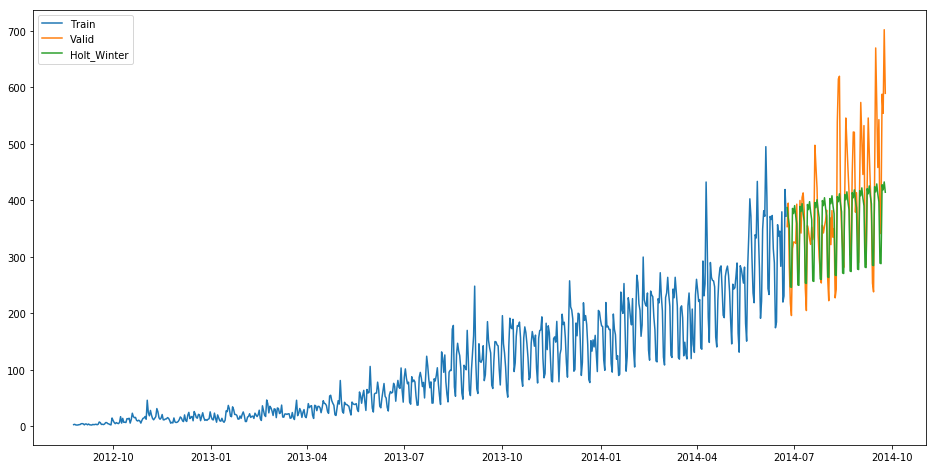

In [169]:
plt.figure(figsize=(16,8)) 
plt.plot( train1['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [170]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter))
print(rms)

82.37467736825413


## Observation : With Holt Winter model : RMSE is reduced to 82.3 compare to other models
forecast the Counts for the entire length of the Test dataset.

In [173]:
predict=fit1.forecast(len(test_dat))
predict

array([387.35988868, 369.13615893, 355.56275513, 247.0903053 ,
       246.19398698, 385.87896172, 376.80242201, 390.85412459,
       372.63039484, 359.05699104, 250.58454121, 249.68822289,
       389.37319763, 380.29665792, 394.3483605 , 376.12463074,
       362.55122695, 254.07877712, 253.1824588 , 392.86743354,
       383.79089383, 397.84259641, 379.61886665, 366.04546286,
       257.57301303, 256.67669471, 396.36166945, 387.28512974,
       401.33683231, 383.11310256, 369.53969877, 261.06724894,
       260.17093062, 399.85590536, 390.77936565, 404.83106822,
       386.60733847, 373.03393468, 264.56148485, 263.66516653,
       403.35014127, 394.27360156, 408.32530413, 390.10157438,
       376.52817059, 268.05572076, 267.15940244, 406.84437718,
       397.76783747, 411.81954004, 393.59581029, 380.0224065 ,
       271.54995667, 270.65363835, 410.33861309, 401.26207337,
       415.31377595, 397.0900462 , 383.51664241, 275.04419258,
       274.14787426, 413.832849  , 404.75630928, 418.80

## Now convert these daily passenger count into hourly passenger count using the same approach which we followed above.

In [177]:
# Merge Test and test_original on day, month and year 
merge1=pd.merge(test_dat, test_Original, on=('day','month', 'year'), how='left') 
merge1['Hour']=merge1['Hour_y'] 
merge1=merge1.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

In [181]:
# Predicting by merging merge and temp2 
prediction2=pd.merge(merge1, t21, on='Hour', how='left') 
prediction2

,ID_x,day,Prediction,ID_y,Hour,ratio
0,18299.5,26,334.650767,18288,0,0.044287
1,18299.5,26,334.650767,18289,1,0.035343
2,18299.5,26,334.650767,18290,2,0.029911
3,18299.5,26,334.650767,18291,3,0.024714
4,18299.5,26,334.650767,18292,4,0.020802
5,18299.5,26,334.650767,18293,5,0.018621
6,18299.5,26,334.650767,18294,6,0.020023
7,18299.5,26,334.650767,18295,7,0.023221
8,18299.5,26,334.650767,18296,8,0.026741
9,18299.5,26,334.650767,18297,9,0.034555


In [182]:
# Converting the ratio to the original scale 
prediction2['Count']=prediction2['Prediction']*prediction['ratio']*24

In [184]:
# drop all features other than ID and Count

prediction2['ID']=prediction2['ID_y'] 
subm2=prediction2.drop(['day','Hour','ratio','Prediction', 'ID_x', 'ID_y'],axis=1) 

In [185]:
# Converting the final submission to csv format 
pd.DataFrame(subm2, columns=['ID','Count']).to_csv('Holt winters.csv')

##  ARIMA model
ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).

Here p is the order of the autoregressive model(number of time lags)
d is the degree of differencing(number of times the data have had past values subtracted)
q is the order of moving average model. We will discuss more about these parameters in next section.

#The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

## Parameter tuning for ARIMA model

First of all we have to make sure that the time series is stationary. If the series is not stationary, we will make it stationary.

Stationarity Check
We use Dickey Fuller test to check the stationarity of the series.
The intuition behind this test is that it determines how strongly a time series is defined by a trend.
The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

Let’s make a function which we can use to calculate the results of Dickey-Fuller test.

## Dickey-Fuller test ( To chk Stationarity)

In [195]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    rolstd = pd.rolling_std(timeseries, window=24)
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
     #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    
    plt.show(block=False)
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
     

C:\Users\inshn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\inshn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  """


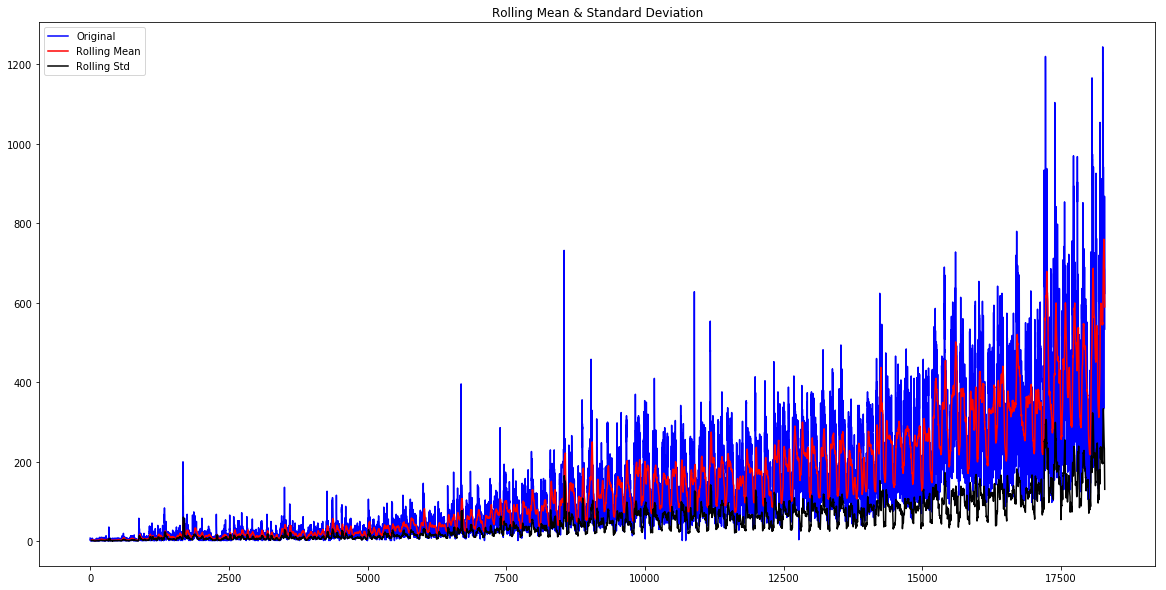

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [196]:
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(train_Original['Count'])